In [20]:
import os
import pandas as pd
import torch
import torch.nn as nn
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt


In [21]:
# 라벨 인코딩을 위한 사전 생성 (훈련 시 사용한 것과 동일해야 함)
label_mapping_large = {
    'BOTTOMS': 0,
    'TOPS': 1
}

# 상의에 대한 라벨 매핑
label_mapping_medium_tops = {
    'LESS': 0,
    'LONG': 1,
    'SHORT': 2
}

label_mapping_small_tops = {
    'LESS': 0,
    'HOODED': 1,
    'NEAT': 2,
    'SHIRTS': 3,
    'SPORTS': 4,
    'SWEAT': 5,
    'POLO': 6,
    'T_SHIRTS': 7
}

label_mapping_major_style_tops = {
    '스포티': 0,
    '캐주얼': 1,
    '미니멀': 2,
    '포멀': 3
}

label_mapping_minor_style_tops = {
    '캐주얼': 0,
    '스트릿': 1,
    '미니멀': 2,
    'nan': 3
}

# 하의에 대한 라벨 매핑
label_mapping_medium_bottoms = {
    'LONG': 0,
    'SHORT': 1
}

label_mapping_small_bottoms = {
    'COTTON': 0,
    'DENIM': 1,
    'LEGGINGS': 2,
    'SLACKS': 3,
    'SPORTS': 4,
    'SWEAT': 5
}

label_mapping_major_style_bottoms = {
    '미니멀': 0,
    '캐주얼': 1,
    '스포티': 2,
    '포멀': 3
}

label_mapping_minor_style_bottoms = {
    '캐주얼': 0,
    '스트릿': 1,
    '미니멀': 2,
    'nan': 3
}


In [24]:
# 장치 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [25]:
# 모델 초기화
def initialize_model(model_path, num_classes):
    model = models.resnext50_32x4d(pretrained=False)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

In [26]:
# 모델 초기화 및 장치 이동
large_category_model = initialize_model('resnext_model_large.pth', len(label_mapping_large)).to(device)
tops_medium_category_model = initialize_model('resnext_model_tops_medium.pth', len(label_mapping_medium_tops)).to(device)
tops_small_category_model = initialize_model('resnext_model_tops_small.pth', len(label_mapping_small_tops)).to(device)
tops_major_style_model = initialize_model('resnext_model_tops_major_style.pth', len(label_mapping_major_style_tops)).to(device)
tops_minor_style_model = initialize_model('resnext_model_tops_minor_style.pth', len(label_mapping_minor_style_tops)).to(device)

bottoms_medium_category_model = initialize_model('resnext_model_bottoms_medium.pth', len(label_mapping_medium_bottoms)).to(device)
bottoms_small_category_model = initialize_model('resnext_model_bottoms_small.pth', len(label_mapping_small_bottoms)).to(device)
bottoms_major_style_model = initialize_model('resnext_model_bottoms_major_style.pth', len(label_mapping_major_style_bottoms)).to(device)
bottoms_minor_style_model = initialize_model('resnext_model_bottoms_minor_style.pth', len(label_mapping_minor_style_bottoms)).to(device)

c:\Users\User\anaconda3\envs\Pytorch_CK\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\User\anaconda3\envs\Pytorch_CK\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\User\AppData\Local\Temp\ipykernel_18652\1747725576.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for 

In [27]:
# 이미지 전처리 변환
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [28]:
# 예측 함수
def predict(image_path):
    # 이미지 로드 및 전처리
    image = Image.open(image_path).convert('RGB')
    image_transformed = transform(image).unsqueeze(0).to(device)  # 배치 차원 추가 및 장치로 이동

    # 대분류 예측
    with torch.no_grad():
        large_outputs = large_category_model(image_transformed)
        _, large_predicted = torch.max(large_outputs, 1)
        large_category = list(label_mapping_large.keys())[large_predicted.item()]

    # 중분류 및 소분류 예측
    if large_category == 'TOPS':
        with torch.no_grad():
            medium_outputs = tops_medium_category_model(image_transformed)
            _, medium_predicted = torch.max(medium_outputs, 1)
            medium_category = list(label_mapping_medium_tops.keys())[medium_predicted.item()]

            small_outputs = tops_small_category_model(image_transformed)
            _, small_predicted = torch.max(small_outputs, 1)
            small_category = list(label_mapping_small_tops.keys())[small_predicted.item()]

            major_outputs = tops_major_style_model(image_transformed)
            _, major_predicted = torch.max(major_outputs, 1)
            major_style = list(label_mapping_major_style_tops.keys())[major_predicted.item()]

            minor_outputs = tops_minor_style_model(image_transformed)
            _, minor_predicted = torch.max(minor_outputs, 1)
            minor_style = list(label_mapping_minor_style_tops.keys())[minor_predicted.item()]

    else:  # 'BOTTOMS'
        with torch.no_grad():
            medium_outputs = bottoms_medium_category_model(image_transformed)
            _, medium_predicted = torch.max(medium_outputs, 1)
            medium_category = list(label_mapping_medium_bottoms.keys())[medium_predicted.item()]

            small_outputs = bottoms_small_category_model(image_transformed)
            _, small_predicted = torch.max(small_outputs, 1)
            small_category = list(label_mapping_small_bottoms.keys())[small_predicted.item()]

            major_outputs = bottoms_major_style_model(image_transformed)
            _, major_predicted = torch.max(major_outputs, 1)
            major_style = list(label_mapping_major_style_bottoms.keys())[major_predicted.item()]

            minor_outputs = bottoms_minor_style_model(image_transformed)
            _, minor_predicted = torch.max(minor_outputs, 1)
            minor_style = list(label_mapping_minor_style_bottoms.keys())[minor_predicted.item()]

    return {
        'large_category': large_category,
        'medium_category': medium_category,
        'small_category': small_category,
        'major_style': major_style,
        'minor_style': minor_style,
        'original_image': image
    }

In [43]:
# 예측할 이미지 경로
image_path = "D:/minkwan/졸업작품/coordikitty-ML-DL/test_image/검정청바지.jpg"  # 예시 이미지 경로
predictions = predict(image_path)

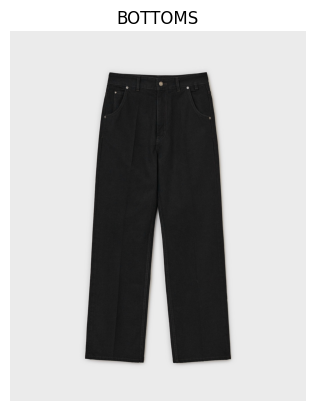

예측 결과:
Large Category: BOTTOMS
Medium Category: LONG
Small Category: COTTON
Major Style: 미니멀
Minor Style: 미니멀


In [44]:
# 이미지 출력
plt.imshow(predictions['original_image'])
plt.axis('off')  # 축 숨기기
plt.title(predictions['large_category'])  # 대분류 제목 추가
plt.show()
# 결과 출력
print("예측 결과:")
print(f"Large Category: {predictions['large_category']}")
print(f"Medium Category: {predictions['medium_category']}")
print(f"Small Category: {predictions['small_category']}")
print(f"Major Style: {predictions['major_style']}")
print(f"Minor Style: {predictions['minor_style']}")